# Final Project - Transforming Real images to Ghibli images

## Abstract:
This project presents an image-to-image translation system that transforms real-world photographs into artwork inspired by the iconic style of Studio Ghibli. By leveraging CycleGAN, Neural Style Transfer, and diffusion models, the system learns to map between photographic and artistic domains without the need for paired training data. The use of cycle-consistency loss ensures semantic content is preserved while applying the desired visual style. This work showcases practical applications in digital art, film production, and creative media, while contributing to advancements in neural style transfer and generative AI.

## Import libraries

In [1]:
# Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image

## Set random seed

In [2]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Paths

In [4]:
# Data paths
REAL_IMAGES_PATH = '/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA'
GHIBLI_IMAGES_PATH = '/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainB_ghibli'


In [5]:
# Hyperparameters
batch_size = 4
image_size = 256
lr = 0.0002
betas = (0.5, 0.999)
n_epochs = 30
lambda_cycle = 10.0
lambda_identity = 0.5 * lambda_cycle
display_step = 100

## Data loading

In [6]:
# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, real_dir, ghibli_dir, transform=None):
        self.real_dir = real_dir
        self.ghibli_dir = ghibli_dir
        self.real_images = sorted(os.listdir(real_dir))
        self.ghibli_images = sorted(os.listdir(ghibli_dir))
        self.transform = transform
        
        # Using the smaller dataset size to ensure equal batches
        self.dataset_size = min(len(self.real_images), len(self.ghibli_images))
        
    def __len__(self):
        return self.dataset_size
    
    def __getitem__(self, idx):
        # Get image paths
        real_path = os.path.join(self.real_dir, self.real_images[idx % len(self.real_images)])
        ghibli_idx = random.randint(0, len(self.ghibli_images) - 1)  # Random unpaired image
        ghibli_path = os.path.join(self.ghibli_dir, self.ghibli_images[ghibli_idx])
        
        # Load images
        real_img = Image.open(real_path).convert('RGB')
        ghibli_img = Image.open(ghibli_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            real_img = self.transform(real_img)
            ghibli_img = self.transform(ghibli_img)
            
        return {'A': real_img, 'B': ghibli_img}

## Data transformation

In [7]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# Create dataset and dataloader
dataset = ImageDataset(REAL_IMAGES_PATH, GHIBLI_IMAGES_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
# Count number of files in each folder
num_real_images = len(os.listdir(REAL_IMAGES_PATH))
num_ghibli_images = len(os.listdir(GHIBLI_IMAGES_PATH))

print(f"Number of real images in trainA: {num_real_images}")
print(f"Number of Ghibli images in trainB_ghibli: {num_ghibli_images}")


Number of real images in trainA: 2500
Number of Ghibli images in trainB_ghibli: 2500


# Methods

## 1. Cycle GAN

In [10]:
# ResNet block for the generator
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# Generator network
class Generator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=9):
        super(Generator, self).__init__()
        
        # Initial convolutional block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, 64, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling layers
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResNetBlock(in_features)]
        
        # Upsampling layers
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_channels, kernel_size=7, padding=0),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

# Discriminator network (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(input_channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize models
G_AB = Generator().to(device)  # Real to Ghibli
G_BA = Generator().to(device)  # Ghibli to Real
D_A = Discriminator().to(device)  # Discriminate Real images
D_B = Discriminator().to(device)  # Discriminate Ghibli images

In [11]:
# Initialize weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

# Define losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Define optimizers
optimizer_G = optim.Adam(
    list(G_AB.parameters()) + list(G_BA.parameters()),
    lr=lr,
    betas=betas
)

optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=betas)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=betas)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=lambda epoch: 1.0 - max(0, epoch - n_epochs//2) / float(n_epochs//2 + 1)
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=lambda epoch: 1.0 - max(0, epoch - n_epochs//2) / float(n_epochs//2 + 1)
)

lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=lambda epoch: 1.0 - max(0, epoch - n_epochs//2) / float(n_epochs//2 + 1)
)

# Create buffer of previously generated images
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        result = []
        for element in data.detach():
            element = element.unsqueeze(0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    result.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    result.append(element)
        return torch.cat(result)

# Initialize buffers
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Create directory for sample images
os.makedirs("cyclegan_samples", exist_ok=True)

# Training tracking
losses = {
    'G_loss': [],
    'G_identity': [],
    'G_GAN': [],
    'G_cycle': [],
    'D_A_loss': [],
    'D_B_loss': []
}

# Sample images for visualization
def save_sample_images(batches_done, real_A, real_B, fake_A, fake_B):
    images = torch.cat([
        real_A.data[:4], 
        fake_B.data[:4],
        real_B.data[:4], 
        fake_A.data[:4]
    ], 0)
    images_grid = make_grid(images, nrow=4, normalize=True)
    save_image(images_grid, f"cyclegan_samples/sample_{batches_done}.png")

# Function to visualize results
def visualize_results(real_A, fake_B, real_B, fake_A, num_images=1):
    fig, axs = plt.subplots(num_images, 4, figsize=(20, 5*num_images))
    
    if num_images == 1:
        axs = axs.reshape(1, -1)
    
    for i in range(num_images):
        # Real A image
        img = real_A[i].detach().cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Denormalize
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Real Photo')
        axs[i, 0].axis('off')
        
        # Fake B (Ghibli-style)
        img = fake_B[i].detach().cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Denormalize
        axs[i, 1].imshow(img)
        axs[i, 1].set_title('Generated Ghibli')
        axs[i, 1].axis('off')
        
        # Real B (Ghibli)
        img = real_B[i].detach().cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Denormalize
        axs[i, 2].imshow(img)
        axs[i, 2].set_title('Real Ghibli')
        axs[i, 2].axis('off')
        
        # Fake A (Photo-like)
        img = fake_A[i].detach().cpu().permute(1, 2, 0).numpy()
        img = (img + 1) / 2  # Denormalize
        axs[i, 3].imshow(img)
        axs[i, 3].set_title('Generated Photo')
        axs[i, 3].axis('off')
    
    plt.tight_layout()
    return fig

# Training function
def train():
    start_time = time.time()
    
    for epoch in range(n_epochs):
        epoch_start_time = time.time()
        epoch_G_loss = 0.0
        epoch_D_A_loss = 0.0
        epoch_D_B_loss = 0.0
        
        for i, batch in enumerate(dataloader):
            # Set model input
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)
            
            # Adversarial ground truths
            valid = torch.ones((real_A.size(0), 1, 16, 16), device=device)
            fake = torch.zeros((real_A.size(0), 1, 16, 16), device=device)
            
            # ------------------
            #  Train Generators
            # ------------------
            
            G_AB.train()
            G_BA.train()
            
            optimizer_G.zero_grad()
            
            # Identity loss
            if lambda_identity > 0:
                # G_AB should be identity if real_B is fed: ||G_AB(B) - B||
                identity_B = G_AB(real_B)
                loss_identity_B = criterion_identity(identity_B, real_B) * lambda_identity
                
                # G_BA should be identity if real_A is fed: ||G_BA(A) - A||
                identity_A = G_BA(real_A)
                loss_identity_A = criterion_identity(identity_A, real_A) * lambda_identity
                
                # Combined identity loss
                loss_identity = loss_identity_A + loss_identity_B
            else:
                loss_identity = 0
            
            # GAN loss
            # A -> B (Real -> Ghibli)
            fake_B = G_AB(real_A)
            pred_fake_B = D_B(fake_B)
            loss_GAN_AB = criterion_GAN(pred_fake_B, valid)
            
            # B -> A (Ghibli -> Real)
            fake_A = G_BA(real_B)
            pred_fake_A = D_A(fake_A)
            loss_GAN_BA = criterion_GAN(pred_fake_A, valid)
            
            # Combined GAN loss
            loss_GAN = loss_GAN_AB + loss_GAN_BA
            
            # Cycle loss
            # A -> B -> A (Forward cycle)
            recovered_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recovered_A, real_A) * lambda_cycle
            
            # B -> A -> B (Backward cycle)
            recovered_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recovered_B, real_B) * lambda_cycle
            
            # Combined cycle loss
            loss_cycle = loss_cycle_A + loss_cycle_B
            
            # Total generator loss
            loss_G = loss_identity + loss_GAN + loss_cycle
            
            loss_G.backward()
            optimizer_G.step()
            
            # -----------------------
            #  Train Discriminator A
            # -----------------------
            
            optimizer_D_A.zero_grad()
            
            # Real loss
            pred_real = D_A(real_A)
            loss_real = criterion_GAN(pred_real, valid)
            
            # Fake loss (using buffer)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            pred_fake = D_A(fake_A_.detach())
            loss_fake = criterion_GAN(pred_fake, fake)
            
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2
            
            loss_D_A.backward()
            optimizer_D_A.step()
            
            # -----------------------
            #  Train Discriminator B
            # -----------------------
            
            optimizer_D_B.zero_grad()
            
            # Real loss
            pred_real = D_B(real_B)
            loss_real = criterion_GAN(pred_real, valid)
            
            # Fake loss (using buffer)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            pred_fake = D_B(fake_B_.detach())
            loss_fake = criterion_GAN(pred_fake, fake)
            
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2
            
            loss_D_B.backward()
            optimizer_D_B.step()
            
            # Update progress and tracking
            epoch_G_loss += loss_G.item()
            epoch_D_A_loss += loss_D_A.item()
            epoch_D_B_loss += loss_D_B.item()
            
            # Print log
            batches_done = epoch * len(dataloader) + i
            if batches_done % display_step == 0:
                time_elapsed = time.time() - start_time
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D_A loss: {loss_D_A.item():.4f}] [D_B loss: {loss_D_B.item():.4f}] "
                      f"[G loss: {loss_G.item():.4f}, identity: {loss_identity.item():.4f}, "
                      f"GAN: {loss_GAN.item():.4f}, cycle: {loss_cycle.item():.4f}] "
                      f"Time elapsed: {time_elapsed:.2f}s")
                
                save_sample_images(batches_done, real_A, real_B, fake_A, fake_B)
        
        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()
        
        # Track epoch losses
        avg_G_loss = epoch_G_loss / len(dataloader)
        avg_D_A_loss = epoch_D_A_loss / len(dataloader)
        avg_D_B_loss = epoch_D_B_loss / len(dataloader)
        
        losses['G_loss'].append(avg_G_loss)
        losses['D_A_loss'].append(avg_D_A_loss)
        losses['D_B_loss'].append(avg_D_B_loss)
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f"[Epoch {epoch}/{n_epochs}] - Time: {epoch_time:.2f}s")
        print(f"  G loss: {avg_G_loss:.4f}, D_A loss: {avg_D_A_loss:.4f}, D_B loss: {avg_D_B_loss:.4f}")
        
        # Save models
        if (epoch + 1) % 10 == 0 or epoch == n_epochs - 1:
            torch.save(G_AB.state_dict(), f"G_AB_epoch_{epoch}.pth")
            torch.save(G_BA.state_dict(), f"G_BA_epoch_{epoch}.pth")
            torch.save(D_A.state_dict(), f"D_A_epoch_{epoch}.pth")
            torch.save(D_B.state_dict(), f"D_B_epoch_{epoch}.pth")
    
    return losses

# Plot training losses
def plot_losses(losses_dict):
    plt.figure(figsize=(10, 6))
    
    # Plot generator loss
    plt.plot(losses_dict['G_loss'], label='Generator')
    
    # Plot discriminator losses
    plt.plot(losses_dict['D_A_loss'], label='Discriminator A')
    plt.plot(losses_dict['D_B_loss'], label='Discriminator B')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('CycleGAN Training Losses')
    plt.grid(True, alpha=0.3)
    plt.savefig('cyclegan_losses.png')
    plt.show()

# Test function for generating images
def test(model_path=None, num_test_images=5):
    # Load trained models if path is provided
    if model_path:
        G_AB.load_state_dict(torch.load(f"{model_path}/G_AB_epoch_99.pth"))
        G_BA.load_state_dict(torch.load(f"{model_path}/G_BA_epoch_99.pth"))
    
    # Set models to eval mode
    G_AB.eval()
    G_BA.eval()
    
    # Create test dataset with different transform (no random flips for testing)
    test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    test_dataset = ImageDataset(REAL_IMAGES_PATH, GHIBLI_IMAGES_PATH, transform=test_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=1)
    
    # Create directory for test results
    os.makedirs("test_results", exist_ok=True)
    
    # Generate and save test images
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            if i >= num_test_images:
                break
                
            # Get real images
            real_A = batch['A'].to(device)
            real_B = batch['B'].to(device)
            
            # Generate fake images
            fake_B = G_AB(real_A)  # Real to Ghibli
            fake_A = G_BA(real_B)  # Ghibli to Real
            
            # Generate cycled images (for visualization)
            cycled_A = G_BA(fake_B)  # Real -> Ghibli -> Real
            cycled_B = G_AB(fake_A)  # Ghibli -> Real -> Ghibli
            
            # Save individual images
            save_image(real_A, f"test_results/test_{i}_real_photo.png", normalize=True)
            save_image(fake_B, f"test_results/test_{i}_fake_ghibli.png", normalize=True)
            save_image(real_B, f"test_results/test_{i}_real_ghibli.png", normalize=True)
            save_image(fake_A, f"test_results/test_{i}_fake_photo.png", normalize=True)
            
            # Visualize and save comparison
            fig = visualize_results(real_A, fake_B, real_B, fake_A)
            plt.savefig(f"test_results/test_{i}_comparison.png")
            plt.close(fig)
            
            # For the first image, also show cycle consistency
            if i == 0:
                cycle_fig, axs = plt.subplots(2, 3, figsize=(15, 10))
                
                # First row: Real A -> Fake B -> Cycled A
                img = real_A[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[0, 0].imshow(img)
                axs[0, 0].set_title('Real Photo')
                axs[0, 0].axis('off')
                
                img = fake_B[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[0, 1].imshow(img)
                axs[0, 1].set_title('Generated Ghibli')
                axs[0, 1].axis('off')
                
                img = cycled_A[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[0, 2].imshow(img)
                axs[0, 2].set_title('Reconstructed Photo')
                axs[0, 2].axis('off')
                
                # Second row: Real B -> Fake A -> Cycled B
                img = real_B[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[1, 0].imshow(img)
                axs[1, 0].set_title('Real Ghibli')
                axs[1, 0].axis('off')
                
                img = fake_A[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[1, 1].imshow(img)
                axs[1, 1].set_title('Generated Photo')
                axs[1, 1].axis('off')
                
                img = cycled_B[0].cpu().permute(1, 2, 0).numpy()
                img = (img + 1) / 2
                axs[1, 2].imshow(img)
                axs[1, 2].set_title('Reconstructed Ghibli')
                axs[1, 2].axis('off')
                
                plt.tight_layout()
                plt.savefig("test_results/cycle_consistency_example.png")
                plt.close(cycle_fig)
    
    print(f"Test complete. Results saved in 'test_results' directory.")


In [12]:
# Run training
print("Starting training...")
training_losses = train()

Starting training...
[Epoch 0/30] [Batch 0/625] [D_A loss: 1.9554] [D_B loss: 2.2476] [G loss: 24.6314, identity: 6.1630, GAN: 6.0737, cycle: 12.3947] Time elapsed: 2.93s
[Epoch 0/30] [Batch 100/625] [D_A loss: 0.2802] [D_B loss: 0.3272] [G loss: 10.1319, identity: 2.8755, GAN: 0.7679, cycle: 6.4885] Time elapsed: 147.02s
[Epoch 0/30] [Batch 200/625] [D_A loss: 0.2735] [D_B loss: 0.2977] [G loss: 9.7402, identity: 2.6083, GAN: 0.7631, cycle: 6.3688] Time elapsed: 291.03s
[Epoch 0/30] [Batch 300/625] [D_A loss: 0.2830] [D_B loss: 0.2233] [G loss: 7.5976, identity: 2.2129, GAN: 0.7435, cycle: 4.6413] Time elapsed: 435.05s
[Epoch 0/30] [Batch 400/625] [D_A loss: 0.2406] [D_B loss: 0.2555] [G loss: 8.6971, identity: 2.2836, GAN: 0.8441, cycle: 5.5694] Time elapsed: 579.04s
[Epoch 0/30] [Batch 500/625] [D_A loss: 0.2700] [D_B loss: 0.1883] [G loss: 6.9105, identity: 1.9656, GAN: 0.7631, cycle: 4.1819] Time elapsed: 723.08s
[Epoch 0/30] [Batch 600/625] [D_A loss: 0.1796] [D_B loss: 0.1682] [

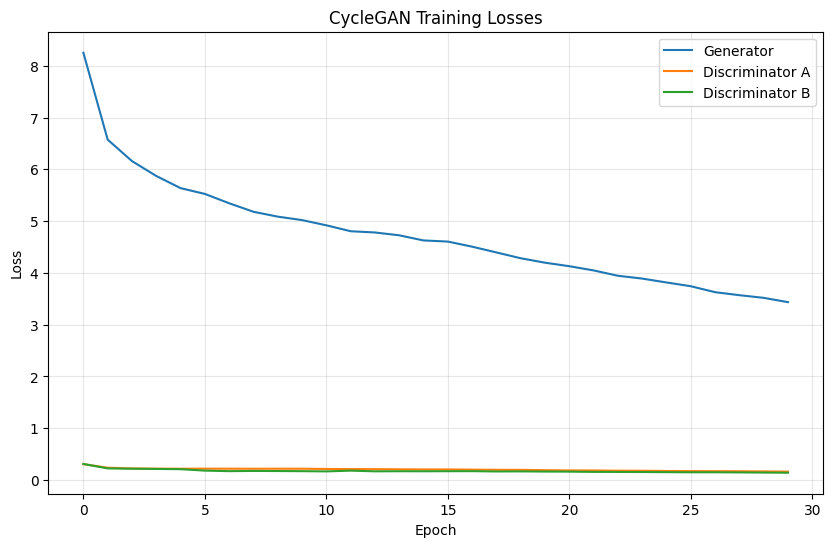

In [13]:
# Plot training losses
plot_losses(training_losses)

In [14]:
# Run testing
print("Running model testing...")
test(num_test_images=5)

Running model testing...
Test complete. Results saved in 'test_results' directory.


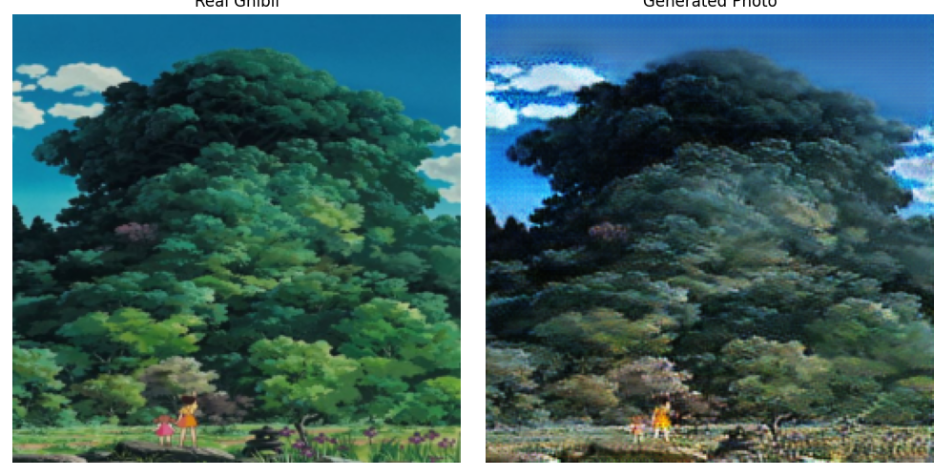

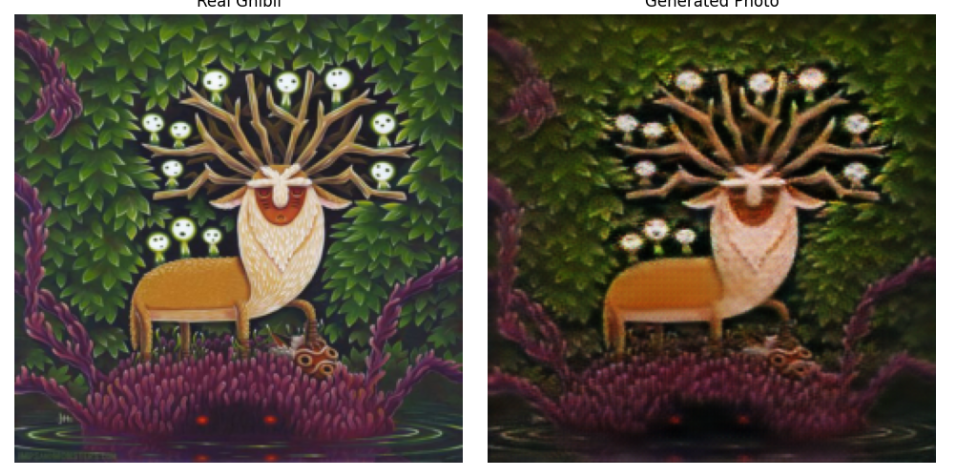

## 2. Neural Style Transfer

In [2]:
# Import libraries
import torch
from torch.autograd import Variable
from collections import namedtuple
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import os
import sys
import random
from PIL import Image
import glob
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import cv2

In [ ]:
def seed_everything(seed):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

Using device: cuda
Training model for Ghibli_Style style
Using style image: /kaggle/input/ghibili-image/stylized_ghibli_image.png
Dataset path: /kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA
Training for 10 epochs with batch size 4
Dataset size: 2500 images


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading style image...
Style features extracted
Sampled 8 images for evaluation
[Epoch 1/10] [Batch 199/625] [Content: 6711516.50 (5713086.86) Style: 4849400.00 (7319603.60) Total: 11560916.00 (13032690.48)]Saved sample at iteration 200
[Epoch 1/10] [Batch 399/625] [Content: 6791265.00 (5400224.90) Style: 3869447.00 (5869395.30) Total: 10660712.00 (11269620.21)]Saved sample at iteration 400
[Epoch 1/10] [Batch 599/625] [Content: 6047653.00 (5251124.56) Style: 3583458.50 (5114967.27) Total: 9631112.00 (10366091.83)]]Saved sample at iteration 600
[Epoch 1/10] [Batch 624/625] [Content: 3892238.75 (5231624.79) Style: 3298091.00 (5040813.97) Total: 7190330.00 (10272438.76)]
Completed epoch 1/10
[Epoch 2/10] [Batch 174/625] [Content: 4739909.00 (4822237.27) Style: 3277208.75 (3124238.96) Total: 8017118.00 (7946476.22)]Saved sample at iteration 800
[Epoch 2/10] [Batch 374/625] [Content: 4402857.00 (4711292.80) Style: 2790884.00 (3008464.40) Total: 7193741.00 (7719757.20)]Saved sample at itera

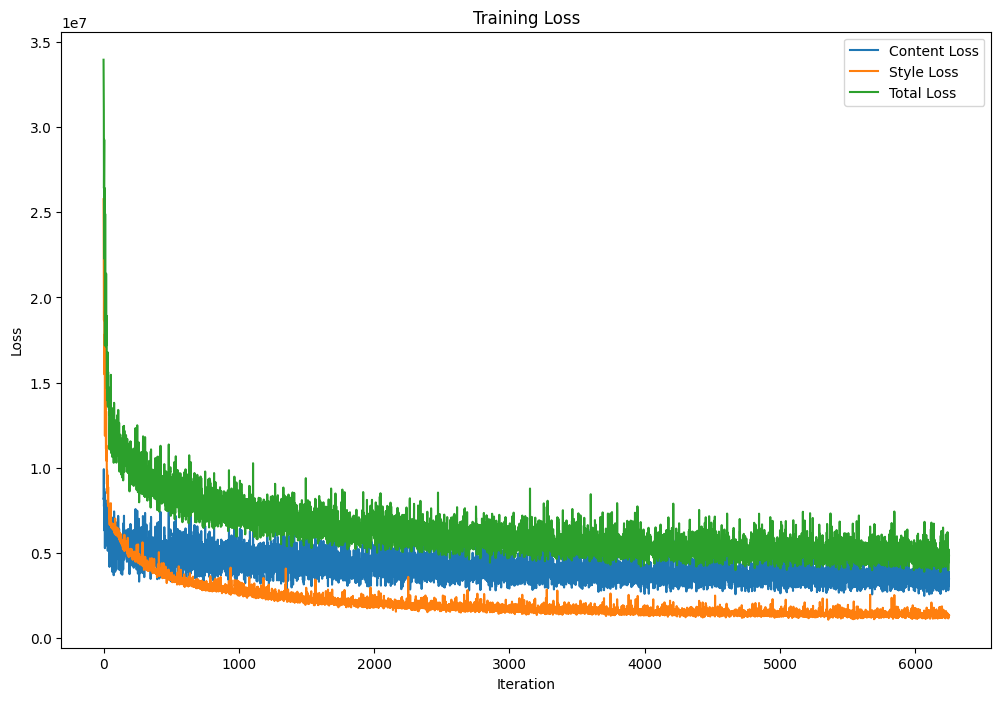

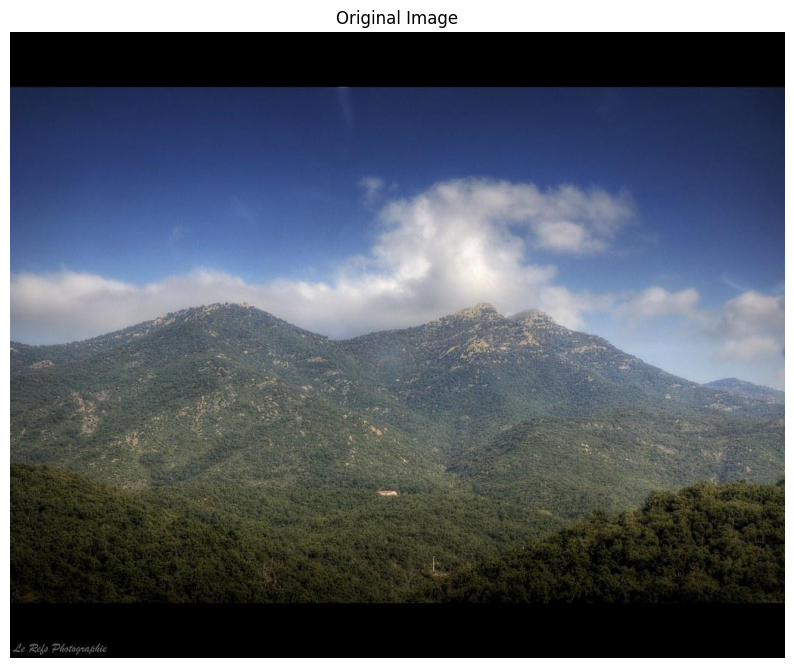

/tmp/ipykernel_31/3711909302.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer.load_state_dict(torch.load(checkpoint_model))


Applying style from checkpoint: /kaggle/working/checkpoints/Ghibli_Style_final.pth
Processing image: /kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA/world_0001.jpg
Stylized image saved to: /kaggle/working/results/world_0001_Ghibli_Style_final.jpg


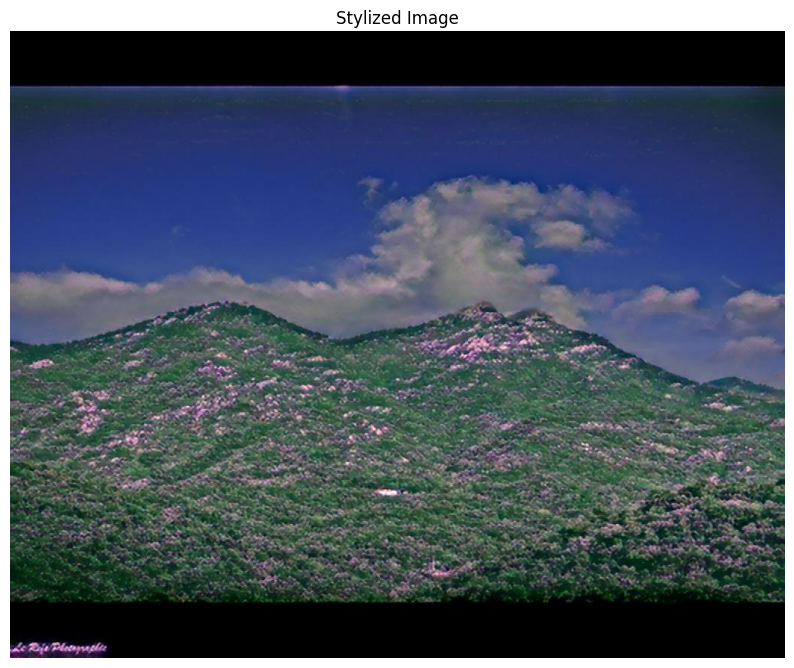

In [4]:
# Set seed and device
seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Mean and standard deviation used for training
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

"""Pretrained VGG16 Model for Feature Extraction"""
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        # Load pretrained VGG model
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        
        # Split VGG features into slices
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
            
        # Freeze parameters
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Extract features at different layers
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        
        # Return extracted features
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out


"""Components of Transformer Net"""
class ResidualBlock(torch.nn.Module):
    """Residual block for the transformer network"""
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x  


class ConvBlock(torch.nn.Module):
    """Conv block with optional normalization, activation, and upsampling"""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), 
            nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x


"""Transformer Net for Style Transfer"""
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Encoder-decoder architecture with residual blocks
        self.model = nn.Sequential(
            # Initial convolution
            ConvBlock(3, 32, kernel_size=9, stride=1),
            # Downsampling
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            # Residual blocks
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            # Upsampling
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            # Final convolution
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)


"""Utility functions"""
def gram_matrix(y):
    """Returns the gram matrix of y (used to compute style loss)"""
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """Transforms for training images"""
    transform = transforms.Compose(
        [
            transforms.Resize((int(image_size * 1.15), int(image_size * 1.15))),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """Transforms for style image"""
    resize = [transforms.Resize((image_size, image_size))] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform


def test_transform(image_size=None):
    """Transforms for test image"""
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform


def denormalize(tensors):
    """Denormalizes image tensors using mean and std"""
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors


def deprocess(image_tensor):
    """Denormalizes and rescales image tensor"""
    image_tensor = denormalize(image_tensor)[0]
    image_tensor *= 255
    image_np = torch.clamp(image_tensor, 0, 255).cpu().numpy().astype(np.uint8)
    image_np = image_np.transpose(1, 2, 0)
    return image_np


# Custom dataset class for Kaggle paths
class ImageFolderWithPaths(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = glob.glob(os.path.join(root, "*.jpg")) + glob.glob(os.path.join(root, "*.png"))
        
    def __getitem__(self, index):
        path = self.image_paths[index]
        image = Image.open(path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, 0  
        
    def __len__(self):
        return len(self.image_paths)


def fast_trainer(style_image_path,
                style_name,
                dataset_path,
                output_dir,
                image_size=256,
                style_size=448,
                batch_size=8,
                lr=1e-5,
                epochs=2,
                checkpoint_model=None,
                checkpoint_interval=200,
                sample_interval=200,
                lambda_style=10e10,
                lambda_content=10e5):
    """Train the style transfer model with Kaggle paths"""
    
    # Create directories for saving outputs
    os.makedirs(os.path.join(output_dir, "images/outputs", f"{style_name}-training"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)

    print(f"Training model for {style_name} style")
    print(f"Using style image: {style_image_path}")
    print(f"Dataset path: {dataset_path}")
    print(f"Training for {epochs} epochs with batch size {batch_size}")

    # Create dataloader for the training data
    train_dataset = ImageFolderWithPaths(dataset_path, train_transform(image_size))
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    print(f"Dataset size: {len(train_dataset)} images")

    # Define networks
    transformer = TransformerNet().to(device)
    vgg = VGG16(requires_grad=False).to(device)

    # Load checkpoint model if specified
    if checkpoint_model:
        print(f"Loading checkpoint model: {checkpoint_model}")
        transformer.load_state_dict(torch.load(checkpoint_model))

    # Define optimizer and loss
    optimizer = Adam(transformer.parameters(), lr)
    l2_loss = torch.nn.MSELoss().to(device)

    # Load style image
    print("Loading style image...")
    style = style_transform(style_size)(Image.open(style_image_path).convert('RGB'))
    style = style.repeat(batch_size, 1, 1, 1).to(device)

    # Extract style features
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]
    print("Style features extracted")

    # Sample images for visual evaluation of the model
    image_samples = []
    sample_paths = random.sample(train_dataset.image_paths, min(8, len(train_dataset.image_paths)))
    for path in sample_paths:
        image_samples += [style_transform(image_size)(Image.open(path).convert('RGB'))]
    image_samples = torch.stack(image_samples)
    print(f"Sampled {len(image_samples)} images for evaluation")

    # Function to save samples during training
    def save_sample(batches_done):
        """Evaluates the model and saves image samples"""
        transformer.eval()
        with torch.no_grad():
            output = transformer(image_samples.to(device))
        image_grid = denormalize(torch.cat((image_samples.cpu(), output.cpu()), 2))
        save_path = os.path.join(output_dir, f"images/outputs/{style_name}-training/{batches_done}.jpg")
        save_image(image_grid, save_path, nrow=4)
        transformer.train()
        print(f"Saved sample at iteration {batches_done}")

    # Training loop
    train_metrics = {"content": [], "style": [], "total": []}
    for epoch in range(epochs):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]
            
            train_metrics["content"] += [content_loss.item()]
            train_metrics["style"] += [style_loss.item()]
            train_metrics["total"] += [total_loss.item()]

            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [Content: %.2f (%.2f) Style: %.2f (%.2f) Total: %.2f (%.2f)]"
                % (
                    epoch + 1,
                    epochs,
                    batch_i,
                    len(dataloader),
                    content_loss.item(),
                    np.mean(epoch_metrics["content"]),
                    style_loss.item(),
                    np.mean(epoch_metrics["style"]),
                    total_loss.item(),
                    np.mean(epoch_metrics["total"]),
                )
            )

            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % sample_interval == 0:
                save_sample(batches_done)

            if checkpoint_interval > 0 and batches_done % checkpoint_interval == 0:
                checkpoint_path = os.path.join(output_dir, f"checkpoints/{style_name}_{batches_done}.pth")
                torch.save(transformer.state_dict(), checkpoint_path)

        # Save checkpoint after each epoch
        checkpoint_path = os.path.join(output_dir, f"checkpoints/{style_name}_epoch_{epoch+1}.pth")
        torch.save(transformer.state_dict(), checkpoint_path)
        print(f"\nCompleted epoch {epoch+1}/{epochs}")

    # Save final model
    final_checkpoint_path = os.path.join(output_dir, f"checkpoints/{style_name}_final.pth")
    torch.save(transformer.state_dict(), final_checkpoint_path)
    print("\nTraining Completed!")
    
    # Plot the loss curve
    plt.figure(figsize=(12, 8))
    plt.plot(train_metrics["content"], label="Content Loss")
    plt.plot(train_metrics["style"], label="Style Loss")
    plt.plot(train_metrics["total"], label="Total Loss")
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    loss_curve_path = os.path.join(output_dir, f"images/outputs/{style_name}_loss_curve.png")
    plt.savefig(loss_curve_path)
    plt.show()
    
    return transformer, final_checkpoint_path


def test_image(image_path, checkpoint_model, save_path, output_size=None):
    """Apply style transfer to a test image"""
    os.makedirs(os.path.join(save_path, "results"), exist_ok=True)

    # Load and transform input image
    transform = test_transform(output_size)
    input_image = Image.open(image_path).convert('RGB')
    
    # Display original image
    plt.figure(figsize=(10, 10))
    plt.imshow(input_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Convert to tensor
    image_tensor = Variable(transform(input_image)).to(device)
    image_tensor = image_tensor.unsqueeze(0)

    # Define model and load model checkpoint
    transformer = TransformerNet().to(device)
    transformer.load_state_dict(torch.load(checkpoint_model))
    transformer.eval()
    
    print(f"Applying style from checkpoint: {checkpoint_model}")
    print(f"Processing image: {image_path}")

    # Stylize image
    with torch.no_grad():
        stylized_image = denormalize(transformer(image_tensor)).cpu()
    
    # Save image
    fn = os.path.basename(image_path).split('.')[0]
    checkpoint_name = os.path.basename(checkpoint_model).split('.')[0]
    output_path = os.path.join(save_path, f"results/{fn}_{checkpoint_name}.jpg")
    save_image(stylized_image, output_path)
    print(f"Stylized image saved to: {output_path}")
    
    # Display stylized image
    plt.figure(figsize=(10, 10))
    plt.imshow(Image.open(output_path))
    plt.title("Stylized Image")
    plt.axis('off')
    plt.show()
    
    return output_path


# Main execution with Kaggle paths
if __name__ == "__main__":
    # Define paths for Kaggle
    ghibli_style_path = "//kaggle/input/satvik/satvik.jpg"
    training_dataset_path = "/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA"
    test_image_path = "/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA/world_0001.jpg"
    output_directory = "/kaggle/working"
    
    # Create output directories
    os.makedirs(os.path.join(output_directory, "images/outputs"), exist_ok=True)
    os.makedirs(os.path.join(output_directory, "checkpoints"), exist_ok=True)
    os.makedirs(os.path.join(output_directory, "results"), exist_ok=True)
    
    # Train the model
    transformer, checkpoint_path = fast_trainer(
        style_image_path=ghibli_style_path,
        style_name="Ghibli_Style",
        dataset_path=training_dataset_path,
        output_dir=output_directory,
        epochs=10,
        batch_size=4,
        lambda_style=10e10,
        lambda_content=10e5,
        checkpoint_interval=500,
        sample_interval=200
    )
    
    # Test the model on a specific image
    test_image(
        image_path=test_image_path,
        checkpoint_model=checkpoint_path,
        save_path=output_directory
    )

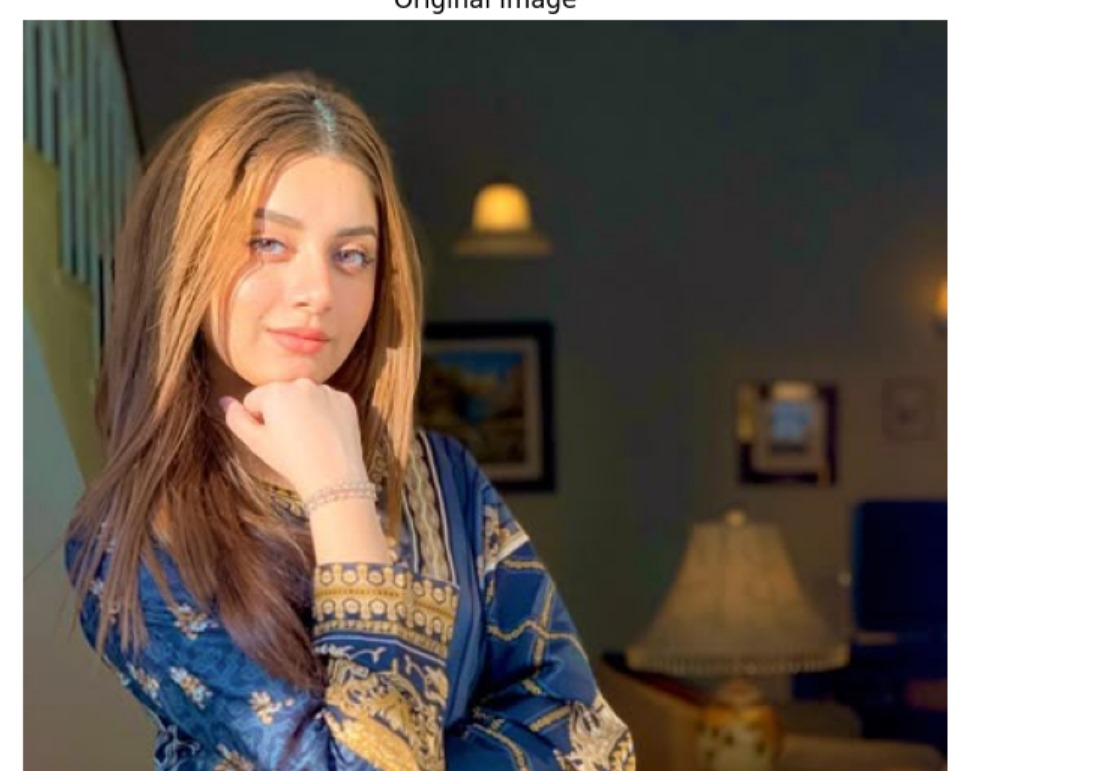

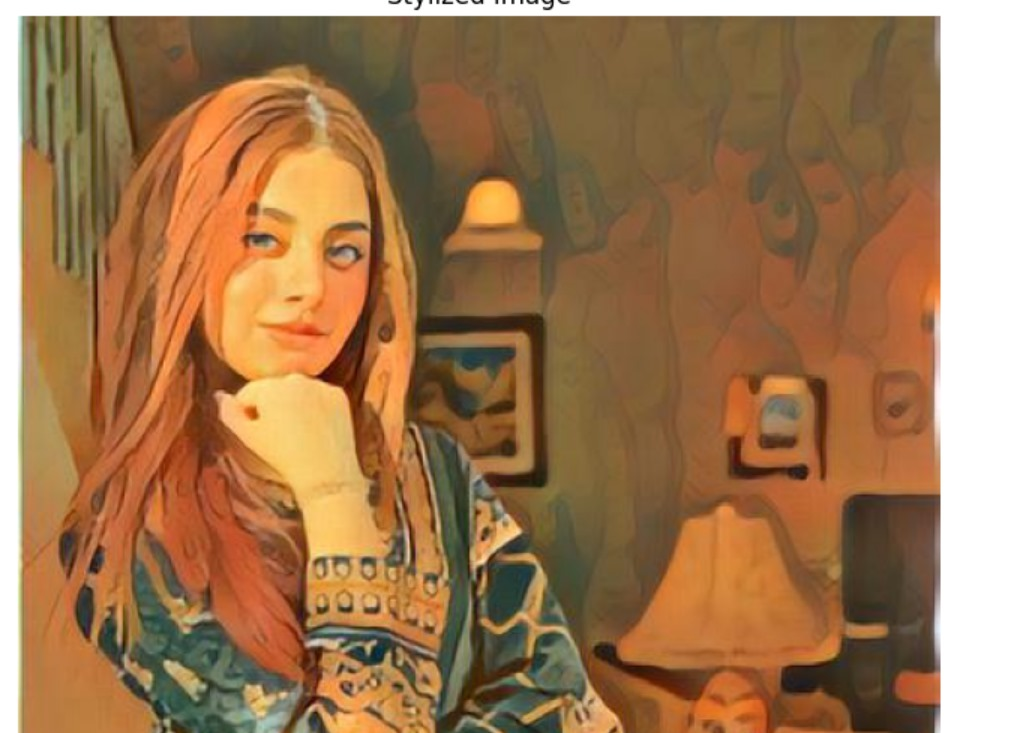

## 3. Nitrosocke Ghibli Diffusion Model

In [3]:
# Import libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionImg2ImgPipeline

2025-05-13 03:31:23.956399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747107084.175116      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747107084.240025      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load the pretrained Ghibli-style model
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "nitrosocke/Ghibli-Diffusion",
    torch_dtype=torch.float16
).to("cuda")

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Load the input image
input_image_path = "/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images/dataset/trainA/world_0004.jpg"
init_image = Image.open(input_image_path).convert("RGB").resize((512, 512))

# Define the prompt
prompt = "A scene in Studio Ghibli style"

# Generate the stylized image
generator = torch.Generator("cuda").manual_seed(42)
output = pipe(
    prompt=prompt,
    image=init_image,
    strength=0.75,
    guidance_scale=7.5,
    generator=generator
).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

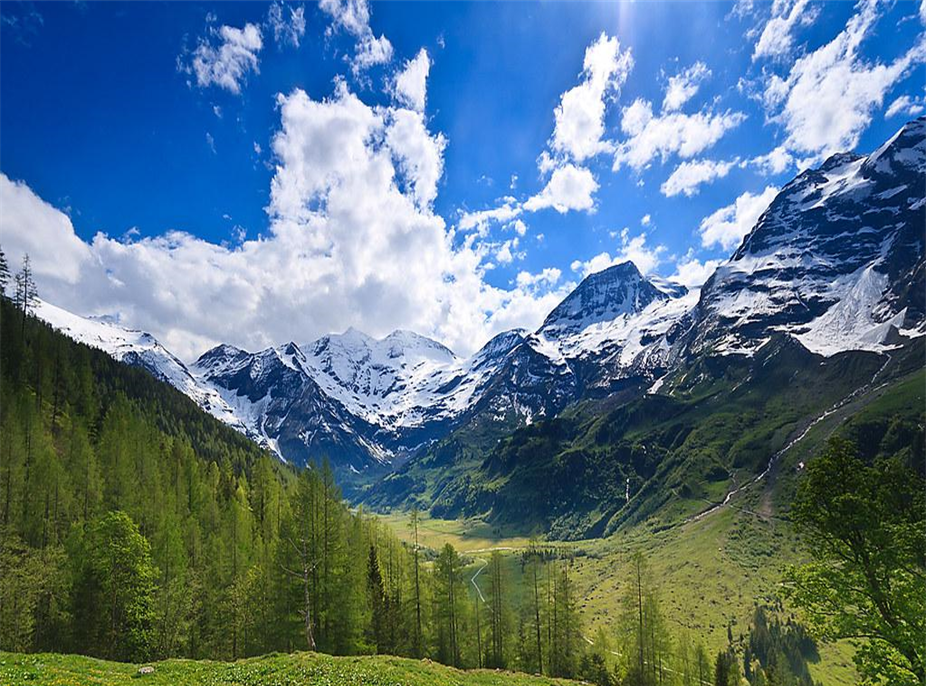

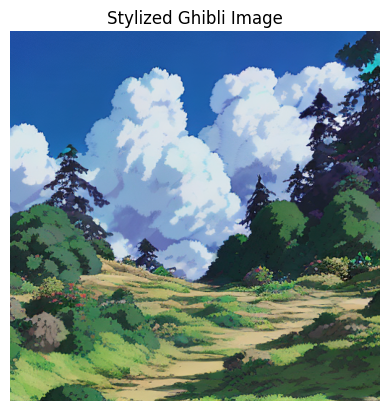

In [6]:
# Display the result inline
plt.imshow(output)
plt.axis("off")
plt.title("Stylized Ghibli Image")
plt.show()

## Comparison

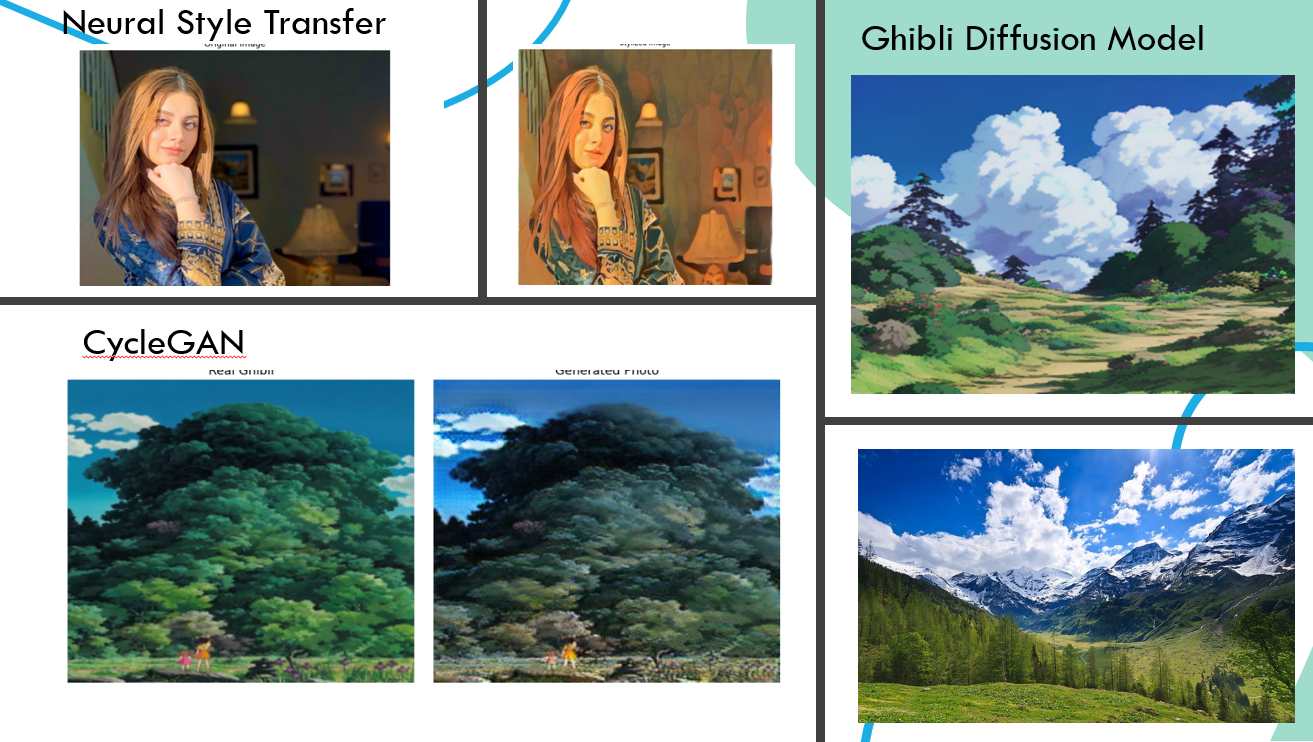

#### Comment:
Compared three style transfer techniques: CycleGAN, Neural Style Transfer, and Ghibli Diffusion Model.
Ghibli Diffusion Model consistently outperformed the others.
It captured Studio Ghibli’s soft, artistic aesthetics with greater clarity and appeal.
Maintained structural details while delivering cohesive, visually pleasing results.
Overall, it was the most effective technique in the comparison.

## Weights Files
 https://drive.google.com/drive/u/0/folders/1E4xUXQCStrzBVU4_QIk6gLQTgi8V63PP


## Research Paper
https://www.researchgate.net/publication/391705055_Transforming_Real_Images_to_Studio_Ghibli_Style_A_Comparative_Study_of_Deep_Learning_Approaches

## Conclusion
Successfully implemented three advanced image translation techniques

Demonstrated unpaired image style transfer

Explored Ghibli artistic style transformation

Established baseline for future research